In [110]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score


In [111]:
grouped_data = pd.read_csv('data/grouped_data.csv')
userdata = pd.read_csv('data/userdata.csv')

In [112]:
# Preprocessing
userdata['graduated_course_ids'] = userdata['graduated_course_ids'].str.split(',')

# Binary encode course completion
mlb = MultiLabelBinarizer()
course_completion = pd.DataFrame(
    mlb.fit_transform(userdata['graduated_course_ids']),
    columns=mlb.classes_,
    index=userdata['user_name']
)

# Cluster users (optional, based on your requirement)
n_clusters = 3  # Adjust number of clusters as needed
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
course_completion['cluster'] = kmeans.fit_predict(course_completion)

In [113]:
# Function to plot spider diagram for user's course progress
def plot_spider(user_name, grouped_data, course_completion):
    if user_name not in course_completion.index:
        print(f"[ERROR] User {user_name} tidak ditemukan.")
        return

    # Mapping learning path to list of courses in it
    learning_path_courses = grouped_data.groupby('Learning Path')['Course ID'].apply(lambda x: list(set(x)))

    # Calculate user progress for each learning path
    user_progress = {
        lp: len(set(courses) & set(course_completion.columns[course_completion.loc[user_name] == 1])) 
        for lp, courses in learning_path_courses.items()
    }

    # Calculate the maximum courses for each learning path
    max_courses = {lp: len(courses) for lp, courses in learning_path_courses.items()}
    progress = [user_progress[lp] / max_courses[lp] if max_courses[lp] > 0 else 0 for lp in learning_path_courses.keys()]

    # Plot spider diagram
    if progress:  # Only proceed if progress exists
        categories = list(learning_path_courses.keys())  # Learning Path names
        values = progress + [progress[0]]  # Close the chart
        angles = np.linspace(0, 2 * np.pi, len(categories), endpoint=False).tolist()
        angles += angles[:1]

        plt.figure(figsize=(8, 8))
        ax = plt.subplot(111, polar=True)
        ax.fill(angles, values, color='blue', alpha=0.25)
        ax.plot(angles, values, color='blue', linewidth=2)
        ax.set_yticks([0.25, 0.5, 0.75, 1])  # Percentage scale
        ax.set_xticks(angles[:-1])
        ax.set_xticklabels(categories, fontsize=10)  # Learning Path names
        plt.title(f'Spider Diagram for {user_name}', size=16)
        plt.show()
    else:
        print("[INFO] Tidak ada progres yang dapat ditampilkan.")


In [114]:
# Function to find similar users using Jaccard similarity
def find_similar_users(user_name, course_completion):
    user_courses = course_completion.loc[:, course_completion.columns]
    target_user = user_courses.loc[user_name]

    similarities = user_courses.apply(
        lambda row: jaccard_score(target_user, row, average="micro"), axis=1
    )
    similarities = similarities.drop(user_name)

    similar_users = similarities.sort_values(ascending=False).index.tolist()
    return similar_users

In [115]:
# Function to recommend courses based on similar users
def recommend_courses(user_name, grouped_data, course_completion):
    if user_name not in course_completion.index:
        raise ValueError(f"User {user_name} tidak ditemukan dalam data course_completion.")

    similar_users = find_similar_users(user_name, course_completion)
    if not similar_users:
        print(f"[INFO] Tidak ada pengguna serupa untuk {user_name}.")
        return []

    # Collect courses completed by similar users
    similar_courses = set()
    for user in similar_users:
        similar_courses.update(course_completion.loc[user][course_completion.loc[user] == 1].index)

    completed_courses = set(course_completion.loc[user_name][course_completion.loc[user_name] == 1].index)
    recommendations = similar_courses - completed_courses

    if not recommendations:
        print("[INFO] Tidak ada rekomendasi course baru yang dapat diberikan.")
        return []

    # Return recommended courses with their learning path
    recommended_courses = []
    for course in recommendations:
        if course in grouped_data['Course ID'].values:
            path_info = grouped_data[grouped_data['Course ID'] == course]
            recommended_courses.append((course, path_info.iloc[0]['Learning Path']))

    return recommended_courses

In [116]:
def plot_spider_diagram(user_name, recommendations):
    """Tampilkan spider diagram untuk learning path yang direkomendasikan."""
    labels = list(recommendations.keys())
    values = list(recommendations.values())

    if len(labels) == 0 or len(values) == 0:
        print("[ERROR] Tidak ada rekomendasi untuk ditampilkan.")
        return  # Stop if no data is available

    # Menambahkan nilai pertama di akhir untuk menutup lingkaran
    labels.append(labels[0])
    values.append(values[0])

    angles = [n / float(len(labels)) * 2 * np.pi for n in range(len(labels))]
    angles.append(angles[0])

    plt.figure(figsize=(6, 6))
    ax = plt.subplot(111, polar=True)
    plt.xticks(angles[:-1], labels, color="grey", size=8)
    ax.plot(angles, values, linewidth=2, linestyle='solid')
    ax.fill(angles, values, alpha=0.4)
    plt.title(f"Learning Path Recommendations for {user_name}", size=14, color="blue", y=1.1)
    plt.show()


Masukkan username Anda:  Felisia


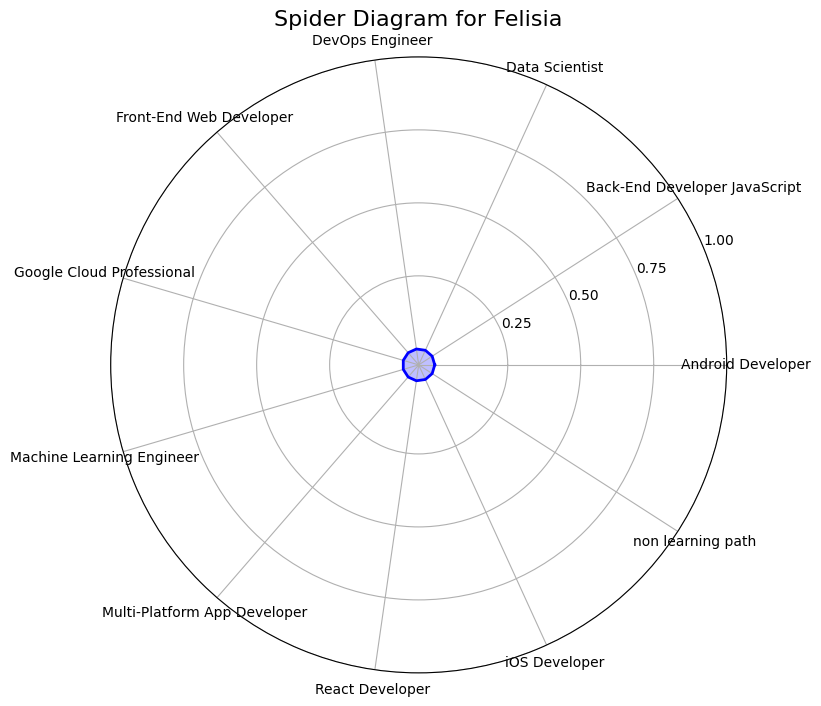

In [119]:
# Main logic
if __name__ == "__main__":
    user_name = input("Masukkan username Anda: ")

    if user_name not in course_completion.index:
        print(f"[ERROR] Username {user_name} tidak ditemukan.")
    else:
        try:
            # Display top 3 recommended courses based on similar users' completions
            recommendations = recommend_courses(user_name, grouped_data, course_completion)
            if recommendations:
                print("Top Recommended Courses:")
                for course, learning_path in recommendations[:3]:
                    print(f"- {learning_path}: Course ID {course}")

            # Display Spider Diagram for user progress
            plot_spider(user_name, grouped_data, course_completion)
        except Exception as e:
            print(f"[ERROR] Terjadi kesalahan: {e}")
